In [1]:
import numpy as np 
from scipy import stats
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
orders = pd.read_csv("orders.csv")
order_items = pd.read_csv("order_items.csv")
promo_codes = pd.read_csv("promo_codes.csv")
restaurants = pd.read_csv("restaurants.csv")
categories = pd.read_csv("categories.csv")
categories_products = pd.read_csv("categories_products.csv")
products = pd.read_csv("products.csv")
stores = pd.read_csv("stores.csv")
invoices = pd.read_csv("invoices.csv")
invoice_items = pd.read_csv("invoice_items.csv")

**Additional Considerations:**
    
Determining profitability on a per order basis:
    Revenue/order-COGS/order($70)

First, need to format table according to prompt's constraints:
1. orders.order_status = 4 and 8 only
2. orders for analysis are to be before 2017-10-01
3. all prices are stored in cents and to be represented in dollars

In [3]:
orders = orders[orders['status'].isin([4, 8])]

orders = orders[(orders['created_at'] < '2017-10-01')]

orders['total'] = orders['total'].div(100)
orders['sub_total'] = orders['sub_total'].div(100)
orders['cart_total'] = orders['cart_total'].div(100)
orders['charged'] = orders['charged'].div(100)
orders['credit_card_charge'] = orders['credit_card_charge'].div(100)

invoices['total'] = invoices['total'].div(100)

Let's take a peek to see if reformatting happened.

In [4]:
orders.head()

,id,created_at,updated_at,edit_up_to,delivery_date,status,total,restaurant_id,sub_total,delivery_fee,...,delivery_time_end,source,credit_card_charge,deleted_at,fill_in,has_frozen_item,has_alcohol_item,store_id,manual_fill_in,volume
1,101,2015-12-28 17:08:47.393476,2017-03-07 16:41:40.138347,2015-12-29 08:00:00,2015-12-29,8,142.65,54,142.65,7500,...,17,NaN,0.0,16:41:40.13079,False,False,False,NaN,False,0.000000
4,11861,2017-03-09 09:30:12.024129,2017-03-14 20:44:22.002984,2017-03-13 08:30:00,2017-03-13,8,684.17,403,692.50,7000,...,18,0.0,0.0,NaN,False,False,False,1.0,False,0.000000
6,9696,2017-01-25 09:32:09.913808,2017-08-22 20:42:35.288515,2017-03-23 08:30:00,2017-03-23,8,533.72,304,520.68,4500,...,18,0.0,0.0,20:42:35.255945,False,True,False,1.0,False,10.000000
31,26219,2017-08-24 08:37:33.23127,2017-11-29 20:07:46.71471,2017-11-29 09:30:00,2017-11-29,4,547.38,439,547.38,5000,...,18,0.0,0.0,NaN,False,False,False,4.0,False,22.327701
32,245,2016-02-01 19:44:19.954347,2016-07-25 14:35:05.767401,2016-02-09 08:00:00,2016-02-09,4,577.59,104,577.59,7500,...,17,NaN,0.0,14:35:05.764617,False,False,False,NaN,False,0.000000


In [5]:
invoices.head()

,id,order_id,created_at,updated_at,status,signed_at,paid_at,payment_method,total,to_pay_to_vendor,...,paid_to_cheetah,paid_to_vendor,deleted_at,charging_platform,verified,updated_by_id,charged_at,failed_at,charged_payment_method_id,disable_direct_payments
0,1604,3453,2016-07-28 11:57:35.306967,2016-07-28 11:57:35.306967,0,NaN,NaN,NaN,0.0,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,1605,3452,2016-07-28 11:57:35.428423,2016-07-28 11:57:35.428423,0,NaN,NaN,NaN,0.0,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,1606,3451,2016-07-28 11:57:35.624098,2016-07-28 11:57:35.624098,0,NaN,NaN,NaN,0.0,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,1607,3450,2016-07-28 11:57:35.897542,2016-07-28 11:57:35.897542,0,NaN,NaN,NaN,0.0,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,1608,3449,2016-07-28 11:57:36.104266,2016-07-28 11:57:36.104266,0,NaN,NaN,NaN,0.0,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


Looks good!

Back to considering profitability:

In [6]:
orders["profit"] = orders.charged-70

In [7]:
orders.head()

,id,created_at,updated_at,edit_up_to,delivery_date,status,total,restaurant_id,sub_total,delivery_fee,...,source,credit_card_charge,deleted_at,fill_in,has_frozen_item,has_alcohol_item,store_id,manual_fill_in,volume,profit
1,101,2015-12-28 17:08:47.393476,2017-03-07 16:41:40.138347,2015-12-29 08:00:00,2015-12-29,8,142.65,54,142.65,7500,...,NaN,0.0,16:41:40.13079,False,False,False,NaN,False,0.000000,NaN
4,11861,2017-03-09 09:30:12.024129,2017-03-14 20:44:22.002984,2017-03-13 08:30:00,2017-03-13,8,684.17,403,692.50,7000,...,0.0,0.0,NaN,False,False,False,1.0,False,0.000000,614.17
6,9696,2017-01-25 09:32:09.913808,2017-08-22 20:42:35.288515,2017-03-23 08:30:00,2017-03-23,8,533.72,304,520.68,4500,...,0.0,0.0,20:42:35.255945,False,True,False,1.0,False,10.000000,463.72
31,26219,2017-08-24 08:37:33.23127,2017-11-29 20:07:46.71471,2017-11-29 09:30:00,2017-11-29,4,547.38,439,547.38,5000,...,0.0,0.0,NaN,False,False,False,4.0,False,22.327701,NaN
32,245,2016-02-01 19:44:19.954347,2016-07-25 14:35:05.767401,2016-02-09 08:00:00,2016-02-09,4,577.59,104,577.59,7500,...,NaN,0.0,14:35:05.764617,False,False,False,NaN,False,0.000000,463.48


Just from a sneak preview of the profit column, we see that there was not profit made all the time. Let us see the overall picture by seeing the trend over time along with comparing it with revenue across time.

Before trending, let us take a look at how many gaps we have in the data since profit column has some NaN's:

In [8]:
orders.isnull().sum()

id                         0
created_at                 0
updated_at                 0
edit_up_to               545
delivery_date             41
status                     0
total                      0
restaurant_id              0
sub_total                  0
delivery_fee               0
last_time_modified         0
cart_total                 0
same_day_charge            0
error_code                 0
taxes                      0
billed                     0
last_job_id              549
manual                     0
uuid                       0
charged                  170
delivery_time_start        0
delivery_time_end          0
source                   331
credit_card_charge         0
deleted_at             28078
fill_in                    0
has_frozen_item            0
has_alcohol_item           0
store_id                  32
manual_fill_in             0
volume                     0
profit                   170
dtype: int64

In [9]:
orders.shape

(28165, 32)

There are 170 NaN's in charged column (and profit column) out of 28165 rows of remaining data. That amounts to about 0.6% of the dataset, not even 1% of the dataset. The data gap is not a problem at this point then.

In [10]:
orders.created_at = pd.to_datetime(orders.created_at)

In [11]:
orders2 = orders[['created_at','charged', 'profit']]

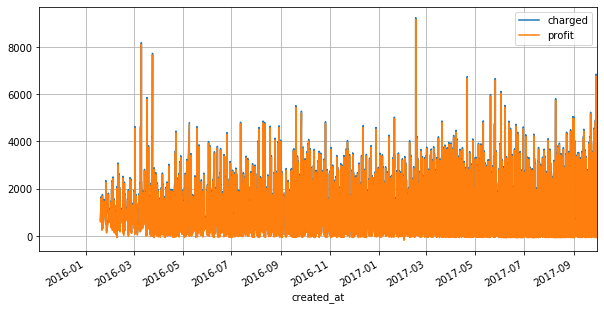

In [12]:
orders2.set_index('created_at').plot(figsize=(10,5), grid=True)

Without charged graph:

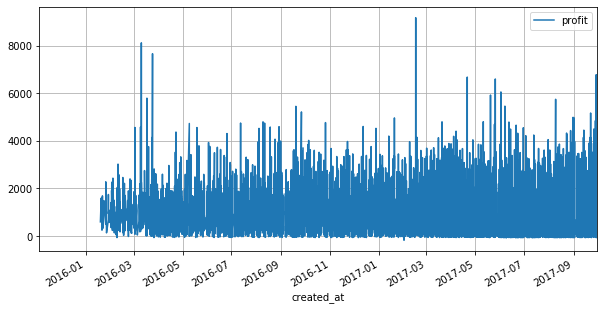

In [16]:
orders2.plot(x='created_at', y='profit', figsize=(10,5), grid=True)

To get granularity of data points, getting most popular values:

In [13]:
orders2.profit.value_counts()

-70.00      84
 309.80      5
-42.91       5
 64.29       4
-60.00       4
            ..
 1134.26     1
 10.29       1
 2237.98     1
-57.14       1
-0.25        1
Name: profit, Length: 25881, dtype: int64

We can see here that profit was not always in the positive. The most occurring value was actually -70 dollars. So most charges were 0 dollars. This is something the business can work on.

Now, let us look at how orders are broken up by customer types.

In [17]:
orders_prom = pd.merge(orders, promo_codes, left_on='id', right_on= 'order_id', how='left')

In [18]:
orders_prom.type.value_counts()

MonthlySubscription    722
FirstDeliveryPromo     176
PercentageDiscount      16
LapsedCustomerPromo      1
Name: type, dtype: int64

Let's visualize this.

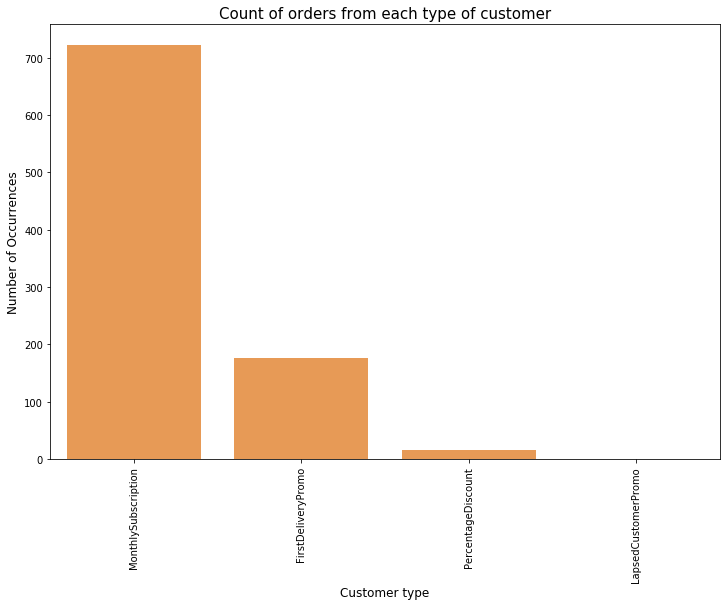

In [19]:
cust_types = orders_prom.type.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cust_types.index, cust_types.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Customer type', fontsize=12)
plt.title('Count of orders from each type of customer', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

NaN's are not included. Need to include them in order to represent the rest of the a la carte customers. NaN's need to be recoded as 'no_promo'.

In [20]:
orders_prom['type'].fillna('no_promo', inplace=True)

In [21]:
orders_prom.type.value_counts()

no_promo               27250
MonthlySubscription      722
FirstDeliveryPromo       176
PercentageDiscount        16
LapsedCustomerPromo        1
Name: type, dtype: int64

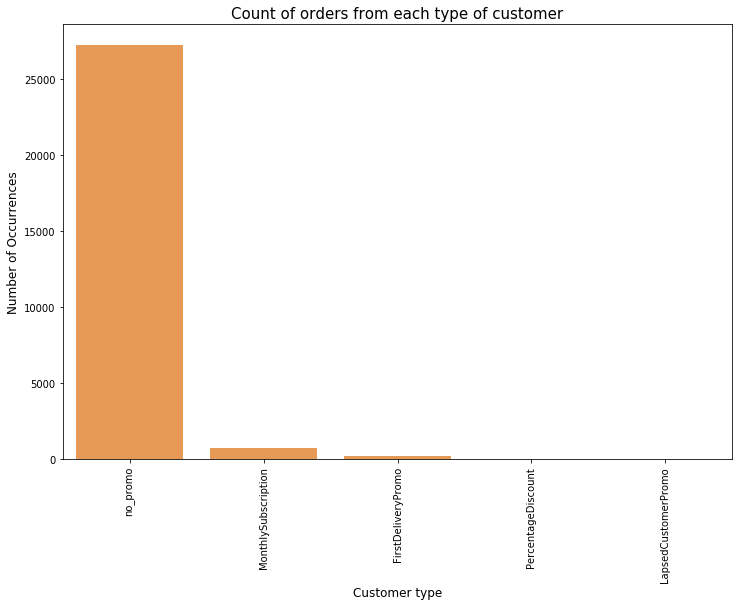

In [22]:
cust_types = orders_prom.type.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cust_types.index, cust_types.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Customer type', fontsize=12)
plt.title('Count of orders from each type of customer', fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

No_promo customers/a la carte customers and then Monthly Subscribers have the highest order volumes.

Now, let's get a visualization of customer types' dollar spent per order.

In [23]:
df = orders_prom.groupby('type')['cart_total'].mean()
df

type
FirstDeliveryPromo      778.360000
LapsedCustomerPromo    1059.150000
MonthlySubscription     836.657064
PercentageDiscount      743.980000
no_promo                809.572466
Name: cart_total, dtype: float64

In [24]:
d = {'type': ['FirstDeliveryPromo', 'LapsedCustomerPromo','MonthlySubscription','PercentageDiscount','no_promo'], 'average_dollar__per_order': [778.360000, 1059.150000, 836.657064, 743.980000, 809.572466]}
df = pd.DataFrame(data=d)
df

,type,average_dollar__per_order
0,FirstDeliveryPromo,778.360000
1,LapsedCustomerPromo,1059.150000
2,MonthlySubscription,836.657064
3,PercentageDiscount,743.980000
4,no_promo,809.572466


Text(0.5, 1.0, 'Average Dollar Per Order by Customer Type')

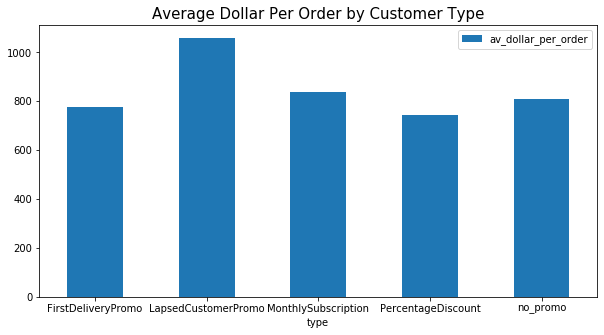

In [25]:
df = pd.DataFrame({'type':['FirstDeliveryPromo', 'LapsedCustomerPromo','MonthlySubscription','PercentageDiscount','no_promo'], 'av_dollar_per_order':[778.360000, 1059.150000, 836.657064, 743.980000, 809.572466]})
ax = df.plot.bar(x='type', y='av_dollar_per_order', rot=0, figsize=(10,5))
plt.title("Average Dollar Per Order by Customer Type", fontsize=15)

The customer who seems to not reorder on time is spending the most per order. Looks like that LapsedCustomerPromo is working out well.

Now let's get a visualization of customer types' revenue per order to see how Cheetah is benefitting from these promotional offers/ customer types.

In [26]:
df2 = orders_prom.groupby('type')['charged'].mean()
df2

type
FirstDeliveryPromo      769.601193
LapsedCustomerPromo            NaN
MonthlySubscription    1166.043670
PercentageDiscount      763.562000
no_promo                861.854900
Name: charged, dtype: float64

Text(0.5, 1.0, 'Average Revenue Per Order by Customer Type')

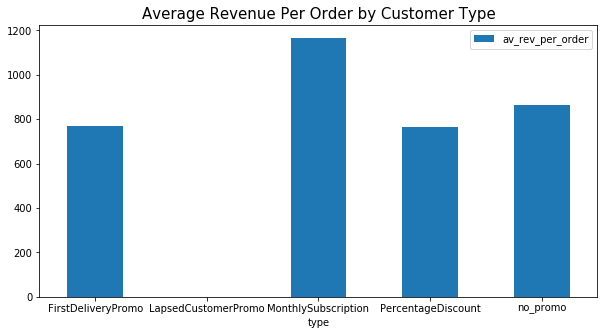

In [27]:
df2 = pd.DataFrame({'type':['FirstDeliveryPromo', 'LapsedCustomerPromo','MonthlySubscription','PercentageDiscount','no_promo'], 'av_rev_per_order':[769.601193, 0, 1166.043670,  763.562000, 861.854900]})
ax = df2.plot.bar(x='type', y='av_rev_per_order', rot=0, figsize=(10,5))
plt.title("Average Revenue Per Order by Customer Type", fontsize=15)

Monthly Subscribers are helping the business a lot. 

Now, let us see which region/market is dominating in orders assuming that each order is being fulfilled by a local Restaurant Depot/Sam's Club.

In [28]:
orders_prom_stores = pd.merge(orders_prom, stores, left_on='store_id', right_on= 'id', how='left')

In [29]:
orders_prom_stores.head()

,id_x,created_at_x,updated_at_x,edit_up_to,delivery_date,status,total,restaurant_id_x,sub_total,delivery_fee,...,restaurant_id_y,expiration_date,price,renewed,period,renew_to_default,id,name,created_at,updated_at
0,101,2015-12-28 17:08:47.393476,2017-03-07 16:41:40.138347,2015-12-29 08:00:00,2015-12-29,8,142.65,54,142.65,7500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11861,2017-03-09 09:30:12.024129,2017-03-14 20:44:22.002984,2017-03-13 08:30:00,2017-03-13,8,684.17,403,692.50,7000,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,RD San Francisco,2015-08-17 23:46:24.891441,2017-11-29 13:14:02.788332
2,9696,2017-01-25 09:32:09.913808,2017-08-22 20:42:35.288515,2017-03-23 08:30:00,2017-03-23,8,533.72,304,520.68,4500,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,RD San Francisco,2015-08-17 23:46:24.891441,2017-11-29 13:14:02.788332
3,26219,2017-08-24 08:37:33.231270,2017-11-29 20:07:46.71471,2017-11-29 09:30:00,2017-11-29,4,547.38,439,547.38,5000,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,RD Oakland,2017-09-20 04:23:23.829306,2017-11-29 13:14:35.884335
4,245,2016-02-01 19:44:19.954347,2016-07-25 14:35:05.767401,2016-02-09 08:00:00,2016-02-09,4,577.59,104,577.59,7500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
orders_prom_stores.name.value_counts()

RD San Francisco      24132
RD Van Nuys            3172
RD Oakland              781
Sam's Club Concord       48
Name: name, dtype: int64

Let us look at suppliers relative to each other to get an idea where most of the fulfillments are.

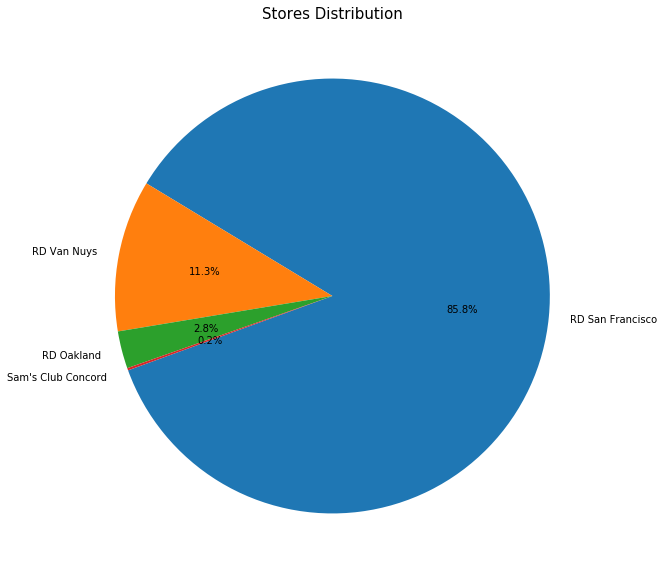

In [31]:
plt.figure(figsize=(10,10))
temp_series = orders_prom_stores['name'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Stores Distribution", fontsize=15)
plt.show()

RD San Francisco reigns.

Let us get a closer look at what sort of products are Monthly Subscribers ordering the most since they are the cause for most of the business' revenue.

First, let's subset the last merged dataset into a smaller DF with only 'MonthlySubscription' type customers.

In [32]:
sub_df = orders_prom_stores.loc[(orders_prom_stores['type'] == 'MonthlySubscription')]

In [33]:
orders_prom_stores_prod = pd.merge(sub_df, products, left_on='id', right_on= 'store_id', how='left')

Let's take a peak at the merge result to see if product info made it in:

In [36]:
orders_prom_stores_prod.head()

,id_x,created_at_x,updated_at_x,edit_up_to,delivery_date,status,total,restaurant_id_x,sub_total,delivery_fee,...,updated_at,id_y,name_y,unit,pack,unit_orderable,unit_per_pack,store_id_y,items_per_unit,units_per_case
0,3855,2016-08-12 08:30:48.215398,2017-01-05 18:10:50.673588,2017-01-04 09:30:00,2017-01-04,8,698.84,69,459.52,30000,...,2017-11-29 13:14:02.788332,12391,Jack Cross Drk Rum 750ml - 12/CS,EA,CS,True,12,1,1.0,12.0
1,3855,2016-08-12 08:30:48.215398,2017-01-05 18:10:50.673588,2017-01-04 09:30:00,2017-01-04,8,698.84,69,459.52,30000,...,2017-11-29 13:14:02.788332,12523,Exec Red Chef Coat Sm,EA,CS,True,1,1,1.0,0.0
2,3855,2016-08-12 08:30:48.215398,2017-01-05 18:10:50.673588,2017-01-04 09:30:00,2017-01-04,8,698.84,69,459.52,30000,...,2017-11-29 13:14:02.788332,8707,Libbey Rocks Glasses 9oz (36 CT),EA,CS,True,1,1,36.0,0.0
3,3855,2016-08-12 08:30:48.215398,2017-01-05 18:10:50.673588,2017-01-04 09:30:00,2017-01-04,8,698.84,69,459.52,30000,...,2017-11-29 13:14:02.788332,1951,Live Blu Claw Crab R/W,EA,CS,True,1,1,NaN,NaN
4,3855,2016-08-12 08:30:48.215398,2017-01-05 18:10:50.673588,2017-01-04 09:30:00,2017-01-04,8,698.84,69,459.52,30000,...,2017-11-29 13:14:02.788332,23559,Zzwndsr Sld Fork,EA,CS,True,1,1,1.0,0.0


Yes! Name_y made it in. Now let us check to see that only MonthlySubcription customers are in the table.

In [37]:
orders_prom_stores_prod.type.value_counts()

MonthlySubscription    9161556
Name: type, dtype: int64

Yes!

In [38]:
cnt_srs = orders_prom_stores_prod['name_y'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Do Not Use,2378
1,"Plate Fm 10"" Wht (500 CT)",1630
2,Winco Stainless Steel Flat Solid Cover for Six...,1444
3,Alegacy Optima III Natural Finish Fry Pan 7 inch,1444
4,Winco Stainless Steel Perforated Steampan Half...,1444
5,Sugar Gran Ex Fine,1444
6,"Strainer Double Mesh 10.25""",1444
7,Pd Flwr Xmas Tree,1444
8,Kumamoto Oysters (60CT),1444
9,Coffeemate 1.58qt Original W/Pump Coffee-MateÂ...,1444


Data table had Do Not Use label frequently. So this was not the most bought, but styrofoam plates along with some steel flat covers and frying pans were the most popular amongst Monthly Subscribers.

Conclusion:
    
    Though Monthly Subscribers only make up a small percentage of the business, they are making up a huge portion of the company's revenue. This is in line with the 80%, 20% rule where most business' revenue comes from a small percentage of the customer base. So after looking at customer behavior across all customer groups, in order to optimize revenue across all different types of customers, it would be a good idea to invest in monthly subscriptions, lapsed customer promotions as well as invest in these customers purchase habits--such as the types of products they order. Also, if time permitted, there could have also been a look at when these different customers make their orders as well as the sequence in which the products they order are placed in their checkout cart to see which products are on their priority list. These are some of the things to keep in mind when looking at ordering behavior in an attempt to optimize revenue across all customer groups.